# Linear Regression Lab - 09/16

## As in previous exercises, please generate a document with all group member names, complete the tasks below, and submit this on Moodle.  Due 09/21.


<img src="cricket.jpg" width=30%>
For centuries, it's been understood that the frequency of cricket chirps increases as temperature increases.  In this problem, you will determine the functional relationship between these two variables such that cricket chirps can be used as a thermometer. 

To begin, import the data file cricket.txt.  The first column is the temperature in degrees C, while the second column is the number of cricket chirps per 15 seconds.  Using scikit-learn's model selection tools, we can split the data into a training set, which will be used to train the model, and a test set, which will be used to validate the model's performance on data that was *not* used to train it.  

In [52]:
import numpy as np
data = np.loadtxt('crickets.txt')

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data[:,0], data[:,1], test_size=0.5, random_state=42)

"""First we Normalize the Data"""
x_mean = np.mean(np.concatenate((X_train, X_test)))
x_std = np.std(np.concatenate((X_train, X_test)))

X_train = (X_train - x_mean) / x_std
X_test = (X_test - x_mean) / x_std

### 1. Ordinary Least Squares (20)
Your first task is to define a function that will fit a polynomial of arbitrary degree to the data, subject to Tikhonov regularization.  To do this you will have to generate the Design matrix $\Phi(X_{obs})$, and solve the normal equations 

$(\Phi^T \Phi + \lambda \mathcal{I}) \mathbf{w} = \phi^T Y_{obs},$

where $\mathbf{w}$ is the vector of polynomial coefficients.  Plot the data with the best-fitting polynomial of degree 1 (a line) overlain.  A handy fact is that if you would like to evaluate this model at some location (or set of locations) $X_{pred}$, the corresponding *prediction* $Y_{pred}$ is given by

$Y_{pred} = \underbrace{\Phi(X_{pred})}_{m\times n} \underbrace{\mathbf{w}}_{n\times 1}.$

As such, it might be helpful to define a function that computes $\Phi(X)$ outside of fit\_polynomial.

In [53]:
def get_phi(x, degree):
    """Create a ones matrix to be populated"""
    phi = np.ones((len(x), degree + 1))
    """Loop through he matrix and multiply each column by the correct x^pow for the column"""
    for i in range(degree + 1):
        phi[:, i] *= x**i
    return phi
# # tests
# x = np.arange(10)
# print(get_phi(x, 2))

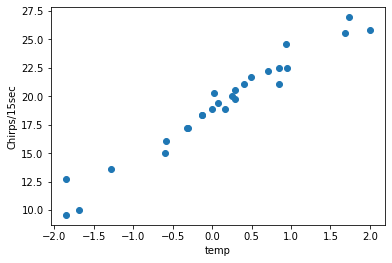

In [54]:
import matplotlib.pyplot as plt
"""Lets take a look at the data"""
plt.scatter(X_train, Y_train)
plt.xlabel("temp")
plt.ylabel("Chirps/15sec")
plt.show()

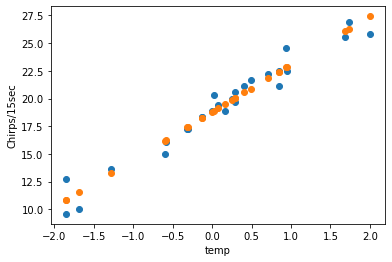

In [55]:
from numpy.polynomial import Polynomial
def fit_polynomial(X, Y, degree, lamb=0):
    """  Find the ordinary least squares fit of an independent 
        variable X to a dependent variable y"""
    Phi = get_phi(X, degree) #!

    """inverse((d+1, X) @ (X, d+1) + constant * (d+1, d+1)) @ ((d+1, X) @ X)"""
    w = np.linalg.inv(Phi.T @ Phi + lamb * np.identity(degree + 1)) @ Phi.T @ Y #!
      
    return w

w_line = fit_polynomial(X_train,Y_train,1)
# print(f"w: {w_line}")

model = Polynomial(w_line)

plt.scatter(X_train, Y_train)
plt.scatter(X_train, model(X_train))
plt.xlabel("temp")
plt.ylabel("Chirps/15sec")
plt.show()



### 2. Overfitting (20)
With the above function in hand, now we will explore the effect of fitting higher degree polynomials to the data.  Fit the training data using polynomials from degree 1 to 15, without regularization (i.e. $\lambda=0$).  For each of these fits, record the resulting root mean square error 

$RMSE = \sqrt{\sum_{i=1}^m (Y_{pred,i} - Y_{obs,i})^2}$

in both the training and test data.  Plot both of these RMSE values as a function of polynomial degree (Using a logarithmic scale for RMSE is helpful).  **In the lab document that you submit, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

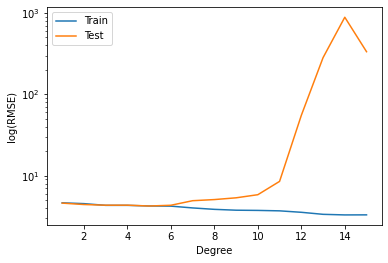

In [56]:
"""You will observe that as we increase the degree of the polynomial, the train and test accuracies will diverge.
This is a defining characteristic of over-fitting."""
train_rmse = []
test_rmse = []
degrees = np.linspace(1,15,15).astype(int)
for d in degrees:
    #! Use the function you generated above to fit
    w = fit_polynomial(X_train, Y_train, d)

    #! a polynomial of degree d to the cricket data
    model = Polynomial(w)
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

    #! Compute and record RMSE for both the training and
    #! test sets.  IMPORTANT: Don't fit a new set of
    #! weights to the test set!!!
    RMSE_train = np.linalg.norm(y_pred_train - Y_train)
    RMSE_test = np.linalg.norm(y_pred_test - Y_test)

    train_rmse.append(RMSE_train)
    test_rmse.append(RMSE_test)

plt.semilogy(degrees,train_rmse, label="Train")
plt.semilogy(degrees,test_rmse, label="Test")
plt.xlabel("Degree")
plt.ylabel("log(RMSE)")
plt.legend()
plt.show()

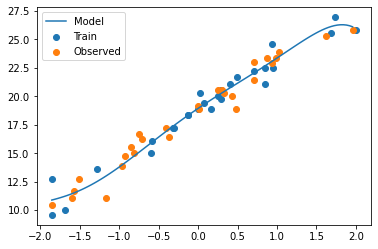

In [60]:
"""They appear to diverge around degree 6. Lets see what that looks like."""

w = fit_polynomial(X_train, Y_train, 6)
model = Polynomial(w)

x = np.linspace(X_test.min(), X_test.max(), 100)
plt.plot(x, model(x), label="Model")
plt.scatter(X_train, Y_train, label="Train")
plt.scatter(X_test, Y_test, label="Observed")
plt.legend()
plt.show()


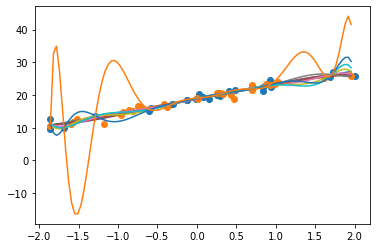

In [69]:
"""Next lets plot all of the models together"""
x = np.linspace(X_test.min(), X_test.max(), 100)
for i in range(1, 13):
    w = fit_polynomial(X_train, Y_train, degree=i)
    model = Polynomial(w)
    plt.plot(x, model(x), label=f"Degree: {i}")

plt.scatter(X_train, Y_train, label="Train")
plt.scatter(X_test, Y_test, label="Observed")
# plt.legend()
plt.show()

### 3. Regularization(*) (20)
Fix the polynomial degree at 15, and now fit the training data for regularization parameter $\lambda \in [10^{-9},10^2]$ (you'll want to distribute these points in log-space; see below).  As above, compute the RMSE in the training and test sets, and plot as a function of $\lambda$.  **In the lab document that you submit, describe the pattern that you see, and explain the reason behind the different behavior between the two curves.**  

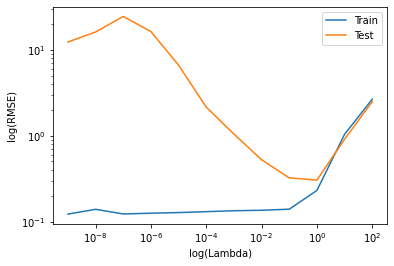

In [58]:
train_rmse = []
test_rmse = []
lamdas = np.logspace(-9,2,12)
d = 15
for lamda in lamdas:
    #! Use the function you generated above to fit
    w = fit_polynomial(X_train, Y_train, 15, lamb=lamda)

    #! a polynomial of degree 15 to the cricket data
    #! with varying lambda
    model = Polynomial(w)
    y_pred_train = model(X_train)
    y_pred_test = model(X_test)

    
    #! Compute and record RMSE for both the training and
    #! test sets.  IMPORTANT: Don't fit a new set of 
    #! weights to the test set!!!
    RMSE_train = np.linalg.norm(y_pred_train - Y_train) / len(Y_train)
    RMSE_test = np.linalg.norm(y_pred_test - Y_test) / len(Y_test)

    train_rmse.append(RMSE_train)
    test_rmse.append(RMSE_test)

plt.loglog(lamdas,train_rmse, label="Train")
plt.loglog(lamdas,test_rmse, label="Test")
plt.xlabel("log(Lambda)")
plt.ylabel("log(RMSE)")
plt.legend()
plt.show()